In [2]:
%matplotlib inline

# 表情数据聚类

In [101]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## 工具函数
Iris中积累下来的一些实用函数

In [109]:
def merge(dfs, title, xlabel="K-value", ylabel="adjusted rand score"):
    df = pd.concat(dfs, axis=1)
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    sns.lineplot(data = df)

In [110]:
def plot_line(title:str, y:list, x:list, line_name:str, xlabel="K-value", ylabel="adjusted rand score"):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    df = pd.DataFrame({line_name: y}, index=x)
    sns.lineplot(data = df)
    
    return df

In [111]:
def plot_count(title:str, x:list, line_name:str, xlabel="K-value", ylabel="adjusted rand score"):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    df = pd.DataFrame({xlabel: x})
    sns.countplot(x=xlabel, data = df)
    
    return df

## 数据获取
读取csv文件，编写Dataset

In [7]:
data_label = pd.read_csv("data/expression-recognition/data_label.csv")
labels = data_label.label
data_label.head()

,pic_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,2
3,3.jpg,0
4,4.jpg,1


查看数据集统计信息

class 0 : 6644
class 1 : 6160
class 2 : 2422
class 3 : 2070
class 4 : 1466
class 5 : 45
class 6 : 301


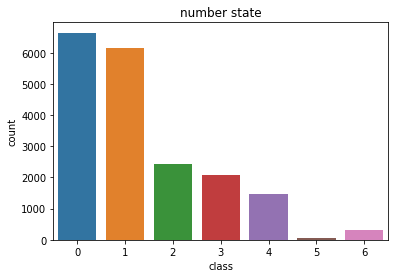

In [8]:
# 统计类别个数
for i in sorted(labels.unique()):
    print('class {} : {}'.format(i, len(labels[labels==i])))
_ = plot_count("number state", labels, "", 'class', 'number')

In [9]:
datapath = "./data/expression-recognition/data"

## 数据预处理
把图像展开成向量

In [10]:
def load_data(data_label, datapath):
    n_rows = len(data_label)
    # n_rows = 5
    serieses = []
    for i in range(n_rows):
        filepath = os.path.join(datapath, data_label.iloc[i].pic_name)
        image_array = np.array(Image.open(filepath))
        image_array = image_array.reshape((1, -1)).squeeze()
        serieses.append(pd.Series(image_array))
    df = pd.DataFrame(serieses)
    return df
        

In [11]:
df = load_data(data_label, datapath)

In [12]:
df

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,93,91,85,81,86,88,76,60,65,54,...,15,14,13,13,24,37,44,56,59,47
1,111,138,139,134,160,179,178,180,194,194,...,204,168,147,127,107,108,80,75,107,89
2,255,251,255,255,210,113,127,130,119,131,...,205,194,181,172,155,154,169,174,171,174
3,42,22,43,43,35,36,27,41,40,13,...,23,24,25,26,24,17,9,2,0,1
4,6,10,10,4,4,13,22,25,17,18,...,11,6,14,6,33,28,31,79,39,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19103,40,30,32,29,37,30,123,218,179,175,...,149,154,166,171,177,179,178,176,177,178
19104,110,113,120,113,113,142,147,111,133,135,...,24,30,16,10,42,0,49,29,45,77
19105,110,141,137,115,113,145,158,113,107,142,...,76,89,79,76,76,77,78,76,74,73
19106,214,200,64,21,43,24,37,28,47,40,...,63,59,81,116,81,91,113,123,95,94


In [13]:
labels = data_label.label
images = df

In [103]:
from sklearn.cluster import KMeans, DBSCAN, Birch, AffinityPropagation
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
sns.set_style('darkgrid')

### 降维

([<matplotlib.axis.XTick at 0x299ed5ecc88>,
 <a list of 15 Text xticklabel objects>)

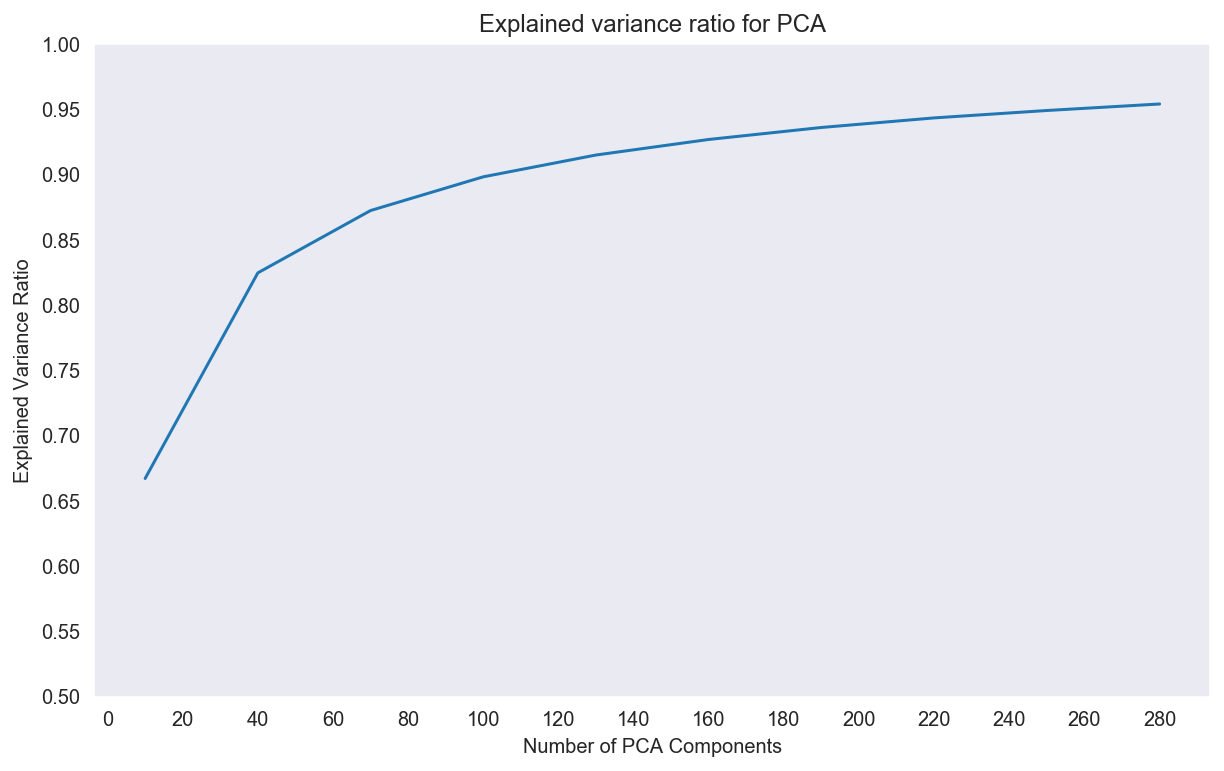

In [15]:
candidate_components = range(10, 300, 30)
explained_ratios = []
for c in candidate_components:
    pca = PCA(n_components=c)
    X_pca = pca.fit_transform(images)
    explained_ratios.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(10, 6), dpi=144)
plt.grid()
plt.plot(candidate_components, explained_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained variance ratio for PCA')
plt.yticks(np.arange(0.5, 1.05, .05))
plt.xticks(np.arange(0, 300, 20))

从300往上看选几好

In [19]:
candidate_components = range(250, 330, 10)
explained_ratios = []
for c in candidate_components:
    pca = PCA(n_components=c)
    X_pca = pca.fit_transform(images)
    print("{} components, explained ratio {}".format(c,np.sum(pca.explained_variance_ratio_)))

250 components, explained ratio 0.9492242576293239
260 components, explained ratio 0.9510127521826616
270 components, explained ratio 0.9526553088223257
280 components, explained ratio 0.9542400003145649
290 components, explained ratio 0.9557354106960472
300 components, explained ratio 0.9571381806661176
310 components, explained ratio 0.9584894142257558
320 components, explained ratio 0.9597866220265104


看样子290差不多了，95.5够用了

In [20]:
data = PCA(n_components=290).fit_transform(images)

K-Means

In [105]:
def k_means_clustering(data, labels, title="", start=2, end=10):
    scores = []
    ks = []
    for i in range(start, end+1):
        ks.append(i)
        pre = KMeans(n_clusters=i).fit_predict(data)
        score = adjusted_rand_score(labels, pre)
        print("adjusted rand score is {:.4f} while k = {}".format(score, i))
        scores.append(score)    
    df = plot_line(title, scores, ks, "KMeans " + title)
    return df

adjusted rand score is 0.0185 while k = 2
adjusted rand score is 0.0181 while k = 3
adjusted rand score is 0.0159 while k = 4
adjusted rand score is 0.0150 while k = 5
adjusted rand score is 0.0140 while k = 6
adjusted rand score is 0.0133 while k = 7
adjusted rand score is 0.0114 while k = 8
adjusted rand score is 0.0108 while k = 9
adjusted rand score is 0.0111 while k = 10


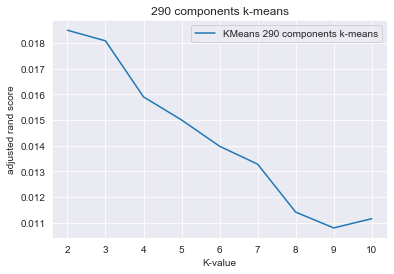

In [21]:
_ = k_means_clustering(data, labels, "290 components k-means")

## 使用Auto Encoder进行降维
PCA效果非常差，需要使用Auto Encoder来降维

In [70]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import pandas as pd
import os
torch.cuda.is_available()

True

### 路径参数

In [65]:
FILEPATH = "./data/expression-recognition"
IMAGE_ROOT = os.path.join(FILEPATH, "data")
LABEL_PATH = os.path.join(FILEPATH, "data_label.csv")
MODEL_PATH = "./models/"

### 数据准备

In [10]:
label_df = pd.read_csv(LABEL_PATH)
label_df

,pic_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,2
3,3.jpg,0
4,4.jpg,1
...,...,...
19103,19103.jpg,3
19104,19104.jpg,0
19105,19105.jpg,1
19106,19106.jpg,0


In [17]:
class EmotionDataset(Dataset):
    def __init__(self, df:pd.DataFrame, imageroot:str, transforms=None):
        super().__init__()
        self.df = df
        self.imageroot = imageroot
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        filename = os.path.join(self.imageroot, self.df.iloc[idx].pic_name)
        image = Image.open(filename)
        # label = self.df.iloc[idx].label
        if self.transforms:
            image = self.transforms(image)
        return image

In [20]:
orig_dataset = EmotionDataset(label_df, IMAGE_ROOT, transforms.ToTensor())
stan_dataset = EmotionDataset(label_df, IMAGE_ROOT, transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]))

In [26]:
orig_dataset[0].size()

torch.Size([1, 48, 48])

### 超参数设置

In [23]:
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 0.001

### 模型构建

In [58]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # input : 1, 48, 48
            nn.Conv2d(1, 4, 2, stride=2),
            nn.ReLU(True),
            # 4, 24, 24
            nn.Conv2d(4, 16, 4, stride=2),
            nn.ReLU(True),
            # 16, 10, 10
            nn.MaxPool2d(2, stride=2),
            # 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            # 8, 3, 3
            nn.MaxPool2d(2, 1)
            # 8, 2, 2
        )
        self.decoder = nn.Sequential(
            # input: 8, 2, 2
            nn.ConvTranspose2d(8, 16, 3, stride=2),
            # nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            # 16, 5, 5
            nn.ConvTranspose2d(16, 16, 2, stride=2),
            nn.ReLU(True),
            # 16, 10, 10
            nn.ConvTranspose2d(16, 4, 6, stride=2),
            nn.ReLU(True),
            # 4, 24, 24
            nn.ConvTranspose2d(4, 1, 2, stride=2),
            nn.Tanh()
            # 1, 48, 48
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### 实例化模型和dataloader

In [59]:
stan_loader = DataLoader(stan_dataset, batch_size=BATCH_SIZE, shuffle=True)
model = AutoEncoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

### 训练

In [74]:
model.train()
for epoch in range(40, 40+EPOCHS):
    losses = []
    for batch_id, data in enumerate(stan_loader):
        data = data.cuda()
        # =================forward===================
        output = model(data)
        loss = criterion(output, data)
        # =================backward==================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # =================log=======================
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, EPOCHS, avg_loss))

    saved_model = os.path.join(MODEL_PATH, "epoch{}_loss{:.4f}.pkl".format(epoch+1, avg_loss))
    torch.save(model.state_dict(), saved_model)


epoch [41/20], loss:0.5836
epoch [42/20], loss:0.5838
epoch [43/20], loss:0.5835
epoch [44/20], loss:0.5833
epoch [45/20], loss:0.5837
epoch [46/20], loss:0.5828
epoch [47/20], loss:0.5841
epoch [48/20], loss:0.5828
epoch [49/20], loss:0.5821
epoch [50/20], loss:0.5829
epoch [51/20], loss:0.5824
epoch [52/20], loss:0.5824
epoch [53/20], loss:0.5825
epoch [54/20], loss:0.5828
epoch [55/20], loss:0.5818
epoch [56/20], loss:0.5820
epoch [57/20], loss:0.5821
epoch [58/20], loss:0.5819
epoch [59/20], loss:0.5820
epoch [60/20], loss:0.5821


In [119]:
model.eval()
arr = None
for batch_id, data in enumerate(stan_loader):
    data = data.cuda()
    out = model.encoder(data)
    out = out.cpu().detach().numpy()
    n_samples = out.shape[0]
    out = out.reshape(n_samples, -1)
    if batch_id == 0:
        arr = out
    else:
        arr = np.concatenate((arr, out), axis=0)

In [120]:
arr.shape

(19108, 32)

In [90]:
small_demo = test_batch[0:5].cuda()

In [91]:
model.eval()
demo_output = model.encoder(small_demo)
demo_array = demo_output.cpu().detach().numpy()
reshaped = demo_array.reshape(5, -1)

In [121]:
k_means_clustering(arr, label_df.label, "test")

adjusted rand score is 0.0002 while k = 2
adjusted rand score is -0.0003 while k = 3
adjusted rand score is -0.0002 while k = 4
adjusted rand score is -0.0001 while k = 5
adjusted rand score is -0.0000 while k = 6
adjusted rand score is 0.0004 while k = 7
adjusted rand score is 0.0001 while k = 8
adjusted rand score is 0.0003 while k = 9
adjusted rand score is 0.0001 while k = 10


,KMeans test
2,0.000186
3,-0.000320
4,-0.000186
5,-0.000127
6,-0.000026
7,0.000436
8,0.000059
9,0.000251
10,0.000128


In [117]:
reshaped.shape

(5, 32)